# Tâche 3 - Classification automatique de descriptions d'incidents

Cette tâche vise à classifier de courts textes décrivant des incidents qui se sont produits sur des chantiers de construction. Pour chaque incident, on retrouve une étiquette de 1 à 4. Ces étiquettes sont inconnues et vous devrez tenter de les identifier à la section 3 de ce *notebook*. 

Les objectifs de cette tâche sont: 
- de se familiariser avec la classification de texte
- d'apprendre à utiliser les fonctions de base de scikit-learn
- de comprendre comment représenter un texte sous la forme d'un sac de mots (*bag of words*)
- de faire l'évaluation d'un modèle de classification avec un corpus de test
- de tenter d'interpréter les résultats d'un modèle à l'aide des poids d'attributs. 

Pour la première partie, vous devez construire une fonction (*train_and_test_classifier*) qui entraîne un modèle (les options étant la régression logistique et le naïf bayésien) et en faire l'évaluation sur des données d'entraînement et des données de test. Deux fichiers de textes sont disponibles pour mener votre expérimentation (voir Section 1). 

Pour la deuxième partie, vous devez tentez de déterminer à quoi correspond chacune des classes d’incident. Faites une analyse des poids des modèles pour proposer des étiquettes pour chacune des classes. Vous pouvez vous inspirer des *notebooks* disponibles sur le site du cours. Expliquez clairement comment vous êtes arrivé à vos conclusions. 

Merci de respecter les signatures des fonctions *train_and_test_classifier* et *load_incident_dataset*.

## Section 1 - Lecture des fichiers de données

Voici les fichiers mis à votre disposition pour mener vos expérimentations. La fonction *load_incident_data* peut être utilisée pour lire les 2 fichiers (train et test). Rien à modifier dans cette section. 

In [1]:
import json

train_json_fn = "./data/t3_train.json"
test_json_fn = "./data/t3_test.json"


def load_incident_dataset(filename):
    with open(filename, 'r') as fp:
        incident_list = json.load(fp)
    return incident_list

In [2]:
train_list = load_incident_dataset(train_json_fn)
print("Nombre d'incidents:", len(train_list))
print("\nUn exemple:\n", train_list[10])

Nombre d'incidents: 2097

Un exemple:
 {'text': ' On February 7  2012 an employee was carrying a 24 inch metal pump jack  scaffolding support that came in contact or near contact with a high voltage  wire. The employee was electrocuted and died.                                   ', 'label': 1}


In [3]:
test_list = load_incident_dataset(test_json_fn)
print("Nombre d'incidents", len(test_list))
incident = test_list[10]
print("\nUne description d'incident:", incident["text"])
print("\nSon étiquette:", incident["label"])

Nombre d'incidents 878

Une description d'incident:  On January 25  2012  Employee#1 and Employee #2 were on the first level of the  one story wooden structure when it collapsed. Employee #1 was able to crawl  out from underneath the fallen structure and received out-patient medical care  for minor injuries. Employee # 2 died at the scene.                             

Son étiquette: 1


## Section 2 - Entraînement et évaluation des modèles  

Vous pouvez ajouter tout le code dont vous avez besoin pour l'entraînement. Merci de ne pas modifier la signature de la fonction d'entraînement et de bien expliquer votre démarche et vos résultats. N'oubliez pas de faire une recommandation de modèle. Vous pouvez ajouter des cellules au *notebook* si nécessaire. 

In [4]:
print(type(train_list))
print(type(train_list[1]))
print(train_list[1].keys())

<class 'list'>
<class 'dict'>
dict_keys(['text', 'label'])


In [5]:
# Visualisation de la matrice de confusion (comme montré dans l'example de cours)
def display_confusion_matrix(confusion_matrix, classes):
    print("\n\nVersion graphique de la matrice de confusion") 
    df_cm = pd.DataFrame(confusion_matrix, index=classes, columns=classes)
    f, ax = plt.subplots(figsize=(7, 5))
    sns.heatmap(df_cm, annot=True, fmt="d", linewidths=.5, ax=ax)
    plt.ylabel('Vrai étiquette')
    plt.xlabel('Étiquette prédite')
    plt.show()

In [6]:
# Importer ici les librairies dont vous avez besoin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Visualisation de la matrice de confusion (comme montré dans l'example de cours)
def display_confusion_matrix(confusion_matrix, classes):
    print("\n\nVersion graphique de la matrice de confusion") 
    df_cm = pd.DataFrame(confusion_matrix, index=classes, columns=classes)
    f, ax = plt.subplots(figsize=(7, 5))
    sns.heatmap(df_cm, annot=True, fmt="d", linewidths=.5, ax=ax, cmap='Blues')
    plt.ylabel('Vrai étiquette')
    plt.xlabel('Étiquette prédite')
    plt.show()

def train_and_test_classifier(train_fn, test_fn, model='NB'):
    """
    :param train_fn et test_fn: les 2 fichiers utilisées pour entraîner et tester les classificateurs.
    :param model: le type de classificateur. NB = Naive Bayes, LR = Régression logistique.
    :return: un dictionnaire contenant 3 valeurs:
                 - l'accuracy à l'entraînement (validation croisée)
                 - l'accuracy sur le jeu de test
                 - la matrice de confusion calculée par scikit-learn sur les données de test
    """

    # Votre code...
    # charger les ensembles de données
    train_list = load_incident_dataset(train_fn)
    test_list = load_incident_dataset(test_fn)

    # allouer les données d'entraînement et de test
    train_txt = [dict['text'] for dict in train_list]
    train_lbl = [dict['label'] for dict in train_list]
    test_txt = [dict['text'] for dict in test_list]
    test_lbl = [dict['label'] for dict in test_list]

    # initialiser le sac de mots 
    vectorizer_bow = CountVectorizer(ngram_range=(1,3),
                                    min_df=2)
    
    # transformer les donées de text
    X_train_bow = vectorizer_bow.fit_transform(train_txt)
    X_test_bow = vectorizer_bow.transform(test_txt)

    # choisir le model
    if model=='LR':
        class_mod = LogisticRegression(max_iter=100, solver='newton-cg')
    elif model=='NB':
        class_mod = MultinomialNB()
    else:
        print('\nUse LR for Logistic Regression or NB for Naive Bayes')
    
    # perte d'entropie croisée pour l'entraînement
    train_scores = cross_val_score(class_mod, X=X_train_bow, y=train_lbl, cv=10)
    train_acc = np.mean(train_scores)

    # entraînement réeel 
    class_mod.fit(X_train_bow, train_lbl)

    # predictions avec les donnnées test
    pred_test = class_mod.predict(X_test_bow)
    test_acc = accuracy_score(test_lbl,pred_test)
    confusion_mat = confusion_matrix(test_lbl,pred_test)

    # formatage de matrice de confusion
    class_names = ['Score 1', 'Score 2', 'Score 3', 'Score 4']
    confusion_mat_beautiful = pd.DataFrame(data=confusion_mat, index=class_names,columns=class_names)
    display_confusion_matrix(confusion_mat, class_names)


    # resultats 
    results = dict()
    results['accuracy_train'] = train_acc
    results['accuracy_test'] = test_acc
    results['confusion_matrix'] = confusion_mat_beautiful  
    results['modèles entraînées'] = model
    
    

    return results, class_mod, vectorizer_bow



Version graphique de la matrice de confusion


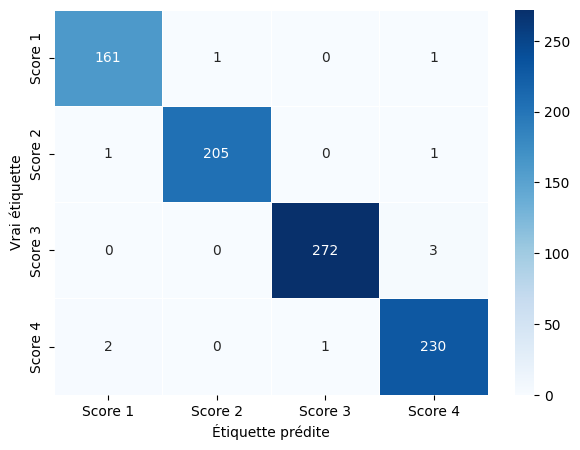

Résultats de la classification:
accuracy_train: 0.9928480291638186
accuracy_test: 0.9886104783599089

confusion_matrix:
         Score 1  Score 2  Score 3  Score 4
Score 1      161        1        0        1
Score 2        1      205        0        1
Score 3        0        0      272        3
Score 4        2        0        1      230
modèles entraînées: LR


In [7]:
results_lr, class_mod_lr, vectorizer_bow_lr = train_and_test_classifier(train_json_fn, test_json_fn, model = 'LR')

print("Résultats de la classification:")
for key, value in results_lr.items():
    if isinstance(value, pd.DataFrame):  # matrice de confusion est un DataFrame
        print(f"\n{key}:")
        print(value)
    else:
        print(f"{key}: {value}")

# training accuracy = 0.9928
# test accuracy = 0.9886
# LR surpasse NB



Version graphique de la matrice de confusion


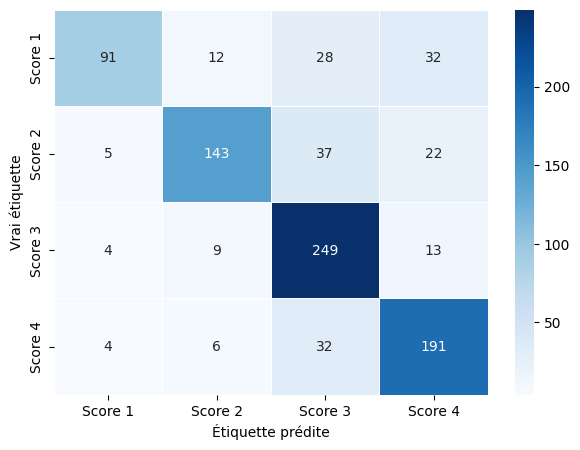

In [8]:
results_nb, class_mod_nb, vectorizer_bow_nb = train_and_test_classifier(train_json_fn, test_json_fn, model= 'NB')


In [9]:
print("Résultats de la classification:")
for key, value in results_nb.items():
    if isinstance(value, pd.DataFrame):  # matrice de confusion est un DataFrame
        print(f"\n{key}:")
        print(value)
    else:
        print(f"{key}: {value}")

# training accuracy = 0.7406
# test accuracy = 0.7676
# NB est surpassé by LR, mais NB est plus vite.

Résultats de la classification:
accuracy_train: 0.7405718842560948
accuracy_test: 0.7676537585421412

confusion_matrix:
         Score 1  Score 2  Score 3  Score 4
Score 1       91       12       28       32
Score 2        5      143       37       22
Score 3        4        9      249       13
Score 4        4        6       32      191
modèles entraînées: NB


On trouve que la regression logistique surpasse Naive Bayes. La accuracy est mieux et on le voit aussi dans la matrice de confusion. Cependant, le NB est plus rapide que la régression logistique. Dans ce cas, cela ne fait pas beaucoup de différence, donc nous recommandons la régression logistique.

## Section 3 - À quoi correspondent les classes? Explicabilité du modèle

En utilisant les poids des modèles, tentez d'attribuer une signification aux différentes classes. Il devrait être possible de définir précisément la nature et la composition des classes. L'important est d'utiliser ce qu'on observe dans les modèles pour fournir une explication plausible.

Vous pouvez ajouter tout le code et toutes les cellules dont vous avez besoin.

In [10]:
# Verifier les labels
class_labels = list(set([dict['label'] for dict in train_list]))
print(class_labels)

[1, 2, 3, 4]


In [11]:
# Obtenir les noms et characteristiques du modèle LR
feature_names = np.array(vectorizer_bow_lr.get_feature_names_out())
coefficients = class_mod_lr.coef_

# trouver les mots les plus importants (positives) pour chaque classe 
for i, label in enumerate(class_labels):
    print(f"\nClass {label}:")
    
    # obtenir les Top 20 indices des mots avec les coefficients plus élevés
    top_indices = np.argsort(coefficients[i])[::-1][:20]
    top_words = feature_names[top_indices]
    top_weights = coefficients[i][top_indices]
    
    # Mettre tout en dataframe
    top_words_df = pd.DataFrame({
        'Word': top_words,
        'Weight': top_weights
    })
    
    print(top_words_df)




Class 1:
              Word    Weight
0       on january  1.435767
1          january  1.427510
2         february  1.412914
3      on february  1.410649
4            march  1.344021
5         on march  1.340287
6      30 on march  0.173536
7    30 on january  0.164036
8   00 on february  0.151849
9             four  0.141103
10   00 on january  0.140058
11            2008  0.134845
12    employee and  0.134177
13     00 on march  0.130739
14   2008 employee  0.122190
15            site  0.118771
16    the employee  0.114732
17           their  0.113060
18         wearing  0.111780
19            fall  0.110583

Class 2:
                      Word    Weight
0                     june  1.608342
1                  on june  1.608094
2                   on may  1.476664
3                      may  1.401691
4                    april  1.372852
5                 on april  1.370316
6                     2013  0.166258
7               30 on june  0.150346
8                    grade  0.133501
9

Basé sur les poids des modèles, nous pensons que les labels correspondent aux saisons de l'année. Les poids les plus élevés du label 1 sont les mois de janvier, février et mars. Pour le label 2, ce sont avril, mai et juin. Pour le label 3 ce sont juillet, août et septembre et pour le label 4 ce sont octobre, novembre et décembre. Par conséquent, nous croyons que les incidents sont classés en fonction de la saison à laquelle ils se sont produits.

## Section 4 - Section réservée pour nos tests